In [3]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append(os.path.abspath('../src'))

from preprocess_station import preprocess_station

In [4]:

pickle_path = '../data/processed/station_data.pkl'
if os.path.exists(pickle_path):
    with open(pickle_path, 'rb') as f:
        station_data = pickle.load(f)
    print("Loaded data from pickle file")
else:
    print("Processed data file not found. Please run the Day 3 notebook first.")

Loaded data from pickle file


NWM columns: Index(['NWM_version_number', 'model_initialization_time',
       'model_output_valid_time', 'streamflow_value', 'streamID', 'lead_time'],
      dtype='object')
USGS columns: Index(['DateTime', 'USGSFlowValue', 'USGS_GageID'], dtype='object')


,model_initialization_time,model_output_valid_time,NWM_streamflow,USGS_streamflow
0,2021-04-21,2021-04-21 01:00:00,0.45,0.19
1,2021-04-21,2021-04-21 01:00:00,0.45,0.19
2,2021-04-21,2021-04-21 01:00:00,0.45,0.19
3,2021-04-21,2021-04-21 02:00:00,0.84,0.19
4,2021-04-21,2021-04-21 02:00:00,0.84,0.19


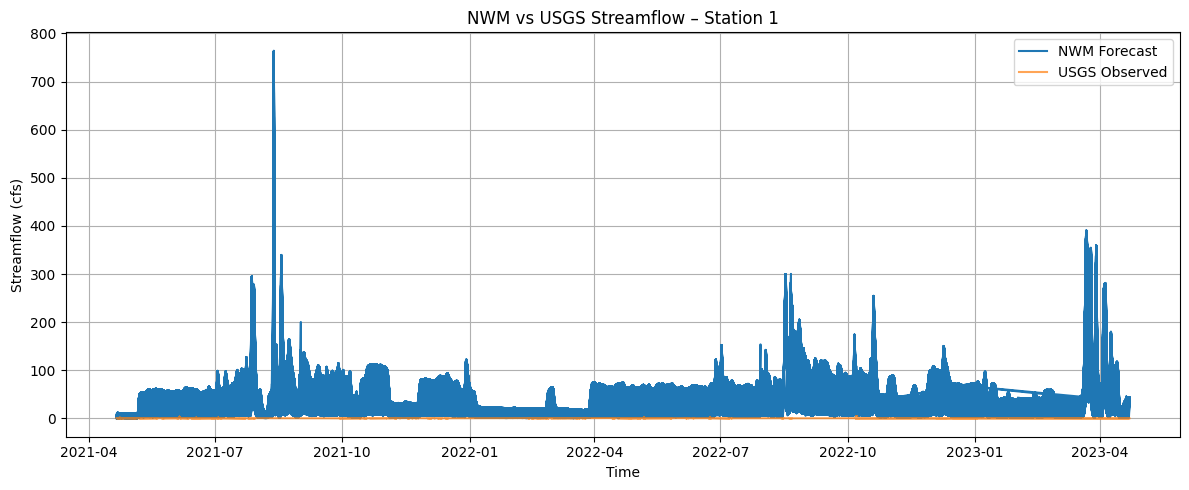

In [5]:
# Process station1
station1_processed = preprocess_station(station_data['station1'])
display(station1_processed.head())

# Save to CSV
station1_processed.to_csv("../data/processed/station1_processed.csv", index=False)

# Plot station1
plt.figure(figsize=(12, 5))
plt.plot(station1_processed['model_output_valid_time'], station1_processed['NWM_streamflow'], label='NWM Forecast')
plt.plot(station1_processed['model_output_valid_time'], station1_processed['USGS_streamflow'], label='USGS Observed', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Streamflow (cfs)")
plt.title("NWM vs USGS Streamflow – Station 1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

NWM columns: Index(['NWM_version_number', 'model_initialization_time',
       'model_output_valid_time', 'streamflow_value', 'streamID', 'lead_time'],
      dtype='object')
USGS columns: Index(['DateTime', 'USGSFlowValue', '00060_cd'], dtype='object')


,model_initialization_time,model_output_valid_time,NWM_streamflow,USGS_streamflow
0,2021-04-21,2021-04-21 01:00:00,30.729999,31.43
1,2021-04-21,2021-04-21 01:00:00,30.729999,31.15
2,2021-04-21,2021-04-21 01:00:00,30.729999,31.43
3,2021-04-21,2021-04-21 02:00:00,31.379999,31.15
4,2021-04-21,2021-04-21 02:00:00,31.379999,31.15


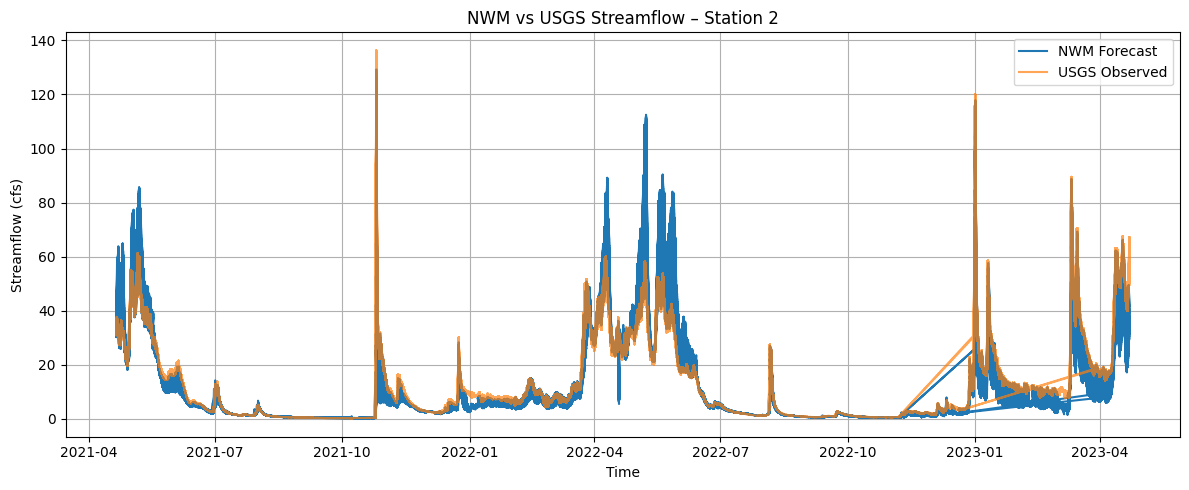

In [6]:
# Process station2
station2_processed = preprocess_station(station_data['station2'])
display(station2_processed.head())

# Save to CSV
station2_processed.to_csv("../data/processed/station2_processed.csv", index=False)

# Plot station2
plt.figure(figsize=(12, 5))
plt.plot(station2_processed['model_output_valid_time'], station2_processed['NWM_streamflow'], label='NWM Forecast')
plt.plot(station2_processed['model_output_valid_time'], station2_processed['USGS_streamflow'], label='USGS Observed', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Streamflow (cfs)")
plt.title("NWM vs USGS Streamflow – Station 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()